In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from cycler import cycler

In [3]:
class_name =  ['Powerline', 'Low Vegetation', 'Impervious Surface', 'Car', 'Fence', 'Roof', 'Facade', 'Shrub', 'Tree']

In [4]:
plt.style.use('default')

## Measurement of every class as feature radius changes (tree number=50)

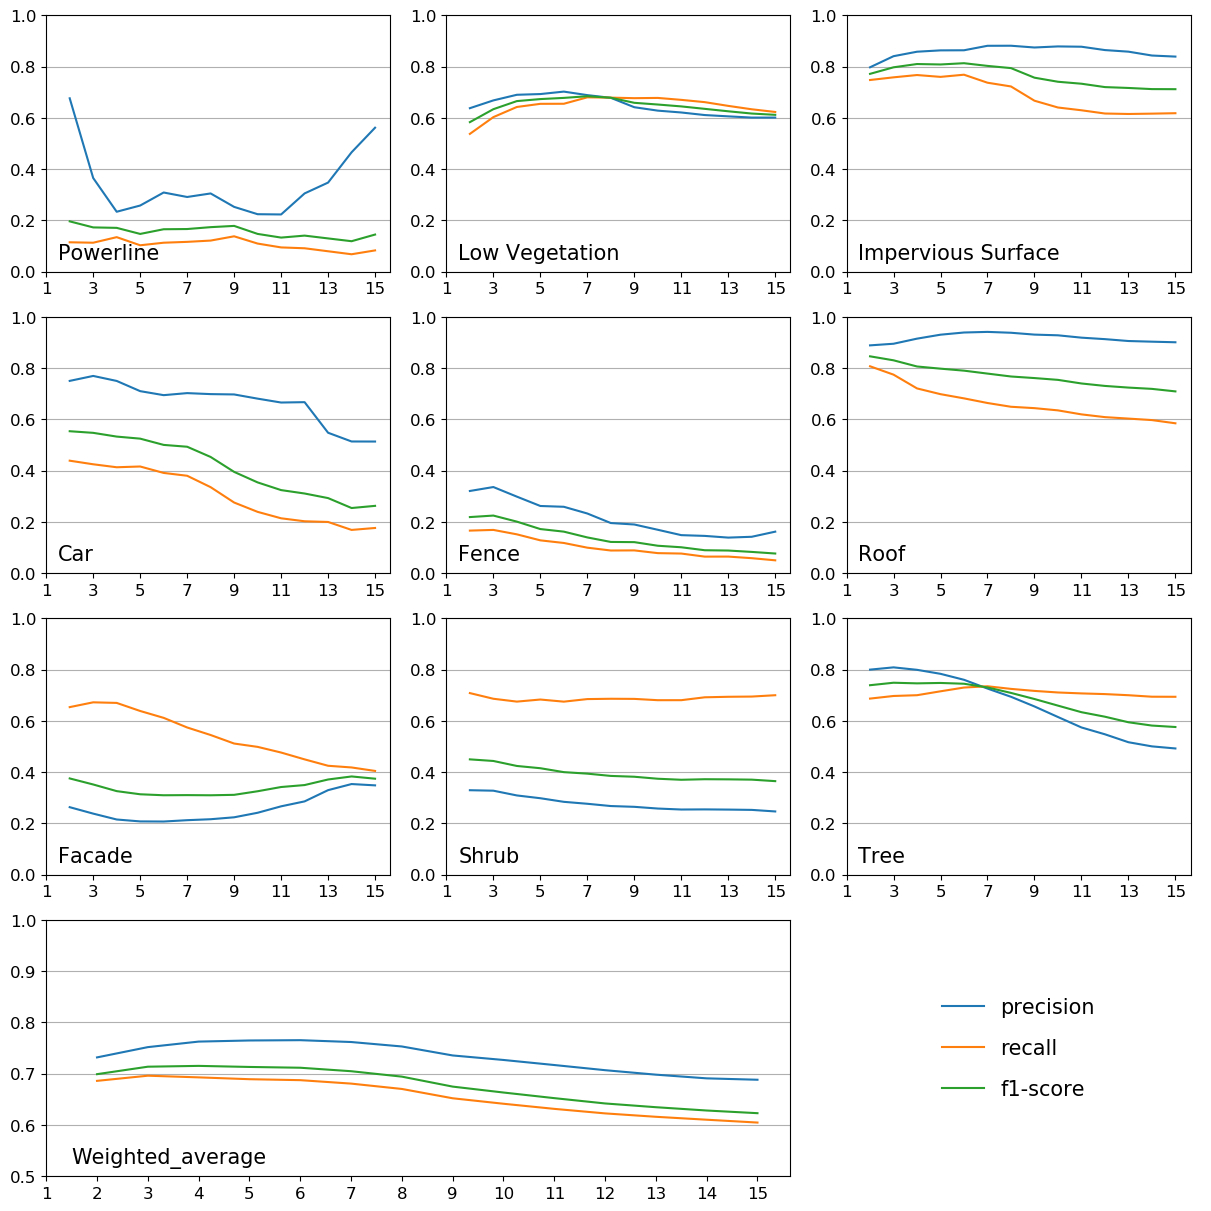

In [5]:
measurement = np.load('final_measure_n50.npy')
x = range(2, 16, 1)
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(4, 3)
for i in range(9):
    row = i//3
    col = i%3
    ax = fig.add_subplot(gs[row, col])
    ax.plot(x, measurement[0, i, :], label='precision')
    ax.plot(x, measurement[1, i, :], label='recall')
    ax.plot(x, measurement[2, i, :], label='f1-score')
    ax.yaxis.set_ticks(np.arange(0, 1.1, 0.2))
    ax.xaxis.set_ticks(np.arange(1, 16, 2))
    ax.text(1.5, 0.05, class_name[i], fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(which='major', axis='y')

ax = fig.add_subplot(gs[-1,0:-1])
ax.plot(x, measurement[0, 9, :], label='precision')
ax.plot(x, measurement[1, 9, :], label='recall')
ax.plot(x, measurement[2, 9, :], label='f1-score')
ax.yaxis.set_ticks(np.arange(0.5, 1.01, 0.1))
ax.xaxis.set_ticks(np.arange(1, 16, 1))
ax.tick_params(axis='both', which='major', labelsize=12)
ax.text(1.5, 0.525, 'Weighted_average', fontsize=15)
ax.grid(which='major', axis='y')
handle, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[-1,-1])
ax.legend(handle, labels, fontsize = 15, ncol = 1, loc='center', frameon=False, labelspacing = 1)
ax.axis('off')
fig.savefig("result.pdf")

## fpfh visualize (radius = 4)

In [6]:
train_data = np.loadtxt('./Vaihingen/fpfh_ground/Vaihingen3D_Traininig_fpfh_4_ground.txt', skiprows=11)

In [7]:
train_data_fpfh = train_data[:, 1:34]
train_data_class = train_data[:, 34]

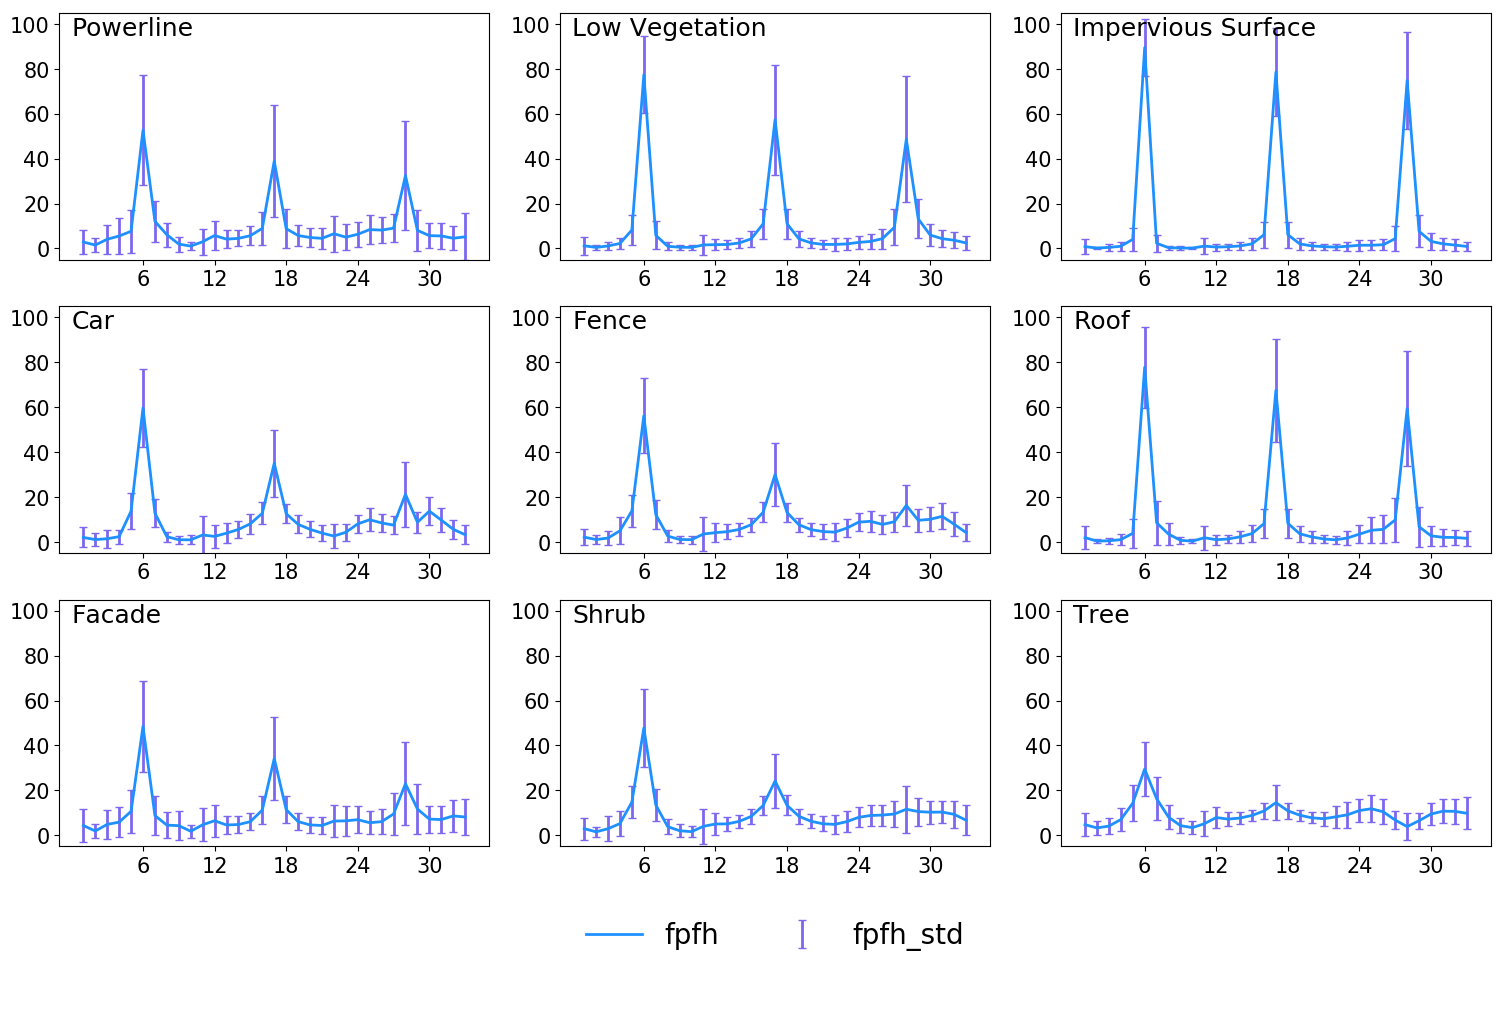

In [8]:
fig = plt.figure(figsize=(15, 10), constrained_layout=True)
widths = [5, 5, 5]
heights = [3, 3, 3, 1]
gs = fig.add_gridspec(ncols=3, nrows=4, width_ratios=widths, height_ratios=heights)

for i in range(len(class_name)):
    specify_class = train_data_class == i
    feature = train_data_fpfh[specify_class]
    feature_std = np.std(feature, axis=0)
    feature_mean = np.mean(feature, axis=0)
    
    row = i//3
    col = i%3
    ax = fig.add_subplot(gs[row, col])
    plot_x = np.arange(len(feature_mean))+1
    ax.errorbar(plot_x, feature_mean, yerr = feature_std, linewidth=0, ecolor='#7b68ee', elinewidth = 2, capsize = 3, label = 'fpfh_std')
    ax.plot(plot_x, feature_mean, color='#1e90ff', lw=2, label = 'fpfh')    
    ax.yaxis.set_ticks(np.arange(0, 101, 20))
    ax.set_ylim(-5,105)
    ax.xaxis.set_ticks(np.arange(6, 34, 6))
    ax.set_xlim(-1,35)
    ax.text(0, 95, class_name[i], fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=15)
handle, labels = ax.get_legend_handles_labels()
ax = fig.add_subplot(gs[-1,:])
ax.legend(handle, labels, fontsize = 20, ncol = 2, loc='center', frameon=False, labelspacing = 3)
ax.axis('off')
fig.savefig("fpfh_radius_4.png")

## Measurement of every class as tree number change

In [9]:
import classify as myclassify

In [10]:
train_data = np.loadtxt('./Vaihingen/fpfh_ground/Vaihingen3D_Traininig_fpfh_4_ground.txt', skiprows=11)
train_data_feature = myclassify.feature_extraction(train_data)
train_data_class = train_data[:, 34]

test_data = np.loadtxt('./Vaihingen/fpfh_ground/Vaihingen3D_EVAL_WITH_REF_fpfh_4_ground.txt', skiprows=11)
test_data_feature = myclassify.feature_extraction(test_data)
test_data_class = test_data[:, 34]

In [20]:
def predict_measure(ground_truth, predict_class):
    precision_recall_fscore = myclassify.precision_recall_fscore_support(ground_truth, predict_class)
    precision_recall_fscore_average = myclassify.precision_recall_fscore_support(ground_truth, predict_class, average='weighted')
    for i in range(3):
        if i == 0:
            measure = np.append(precision_recall_fscore[i], precision_recall_fscore_average[i])
        else:
            tmp = np.append(precision_recall_fscore[i], precision_recall_fscore_average[i])
            measure = np.vstack((measure, tmp))
    return measure

In [21]:
for count_learnbase in range(5, 105, 5):
    X_resampled, y_resampled = myclassify.resample_data(train_data_feature, train_data_class, count_learnbase)
    clf_estimator = myclassify.train_brf(X_resampled, y_resampled, count_learnbase)
    test_predict = myclassify.predict_brf(clf_estimator, test_data_feature)
    test_precision_recall_fscore = predict_measure(test_data_class, test_predict)
    
    train_predict = myclassify.predict_brf(clf_estimator, train_data_feature) 
    train_precision_recall_fscore = predict_measure(train_data_class, train_predict)
    if count_learnbase == 5:
        final_test_prf = test_precision_recall_fscore
        final_train_prf = train_precision_recall_fscore
    else:
        final_test_prf = np.dstack((final_test_prf, test_precision_recall_fscore))
        final_train_prf = np.dstack((final_train_prf, train_precision_recall_fscore))
np.save('./classify_output/test_prf_with_tree_number', final_test_prf)
np.save('./classify_output/train_prf_with_tree_number', final_train_prf)

In [25]:
final_train_prf.shape

(3, 10, 2)

In [26]:
final_train_prf[:,:, 1]

array([[0.58899676, 0.89707794, 0.94327307, 0.8541281 , 0.81      ,
        0.99605782, 0.7446861 , 0.66943915, 0.99708636, 0.92507997],
       [1.        , 0.88153719, 0.90410535, 1.        , 0.99991715,
        0.95719031, 0.99768807, 0.97384728, 0.86583119, 0.91251214],
       [0.7413442 , 0.88923967, 0.92327399, 0.92132588, 0.89499444,
        0.97623735, 0.85281847, 0.7934484 , 0.92683487, 0.91508846]])